In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [14]:
INIT_LR = 1e-3
EPOCHS = 20
BS = 8
dataset = "/content/gdrive/My Drive/skin-cancer-dataset"

In [4]:
args={}
args["dataset"]=dataset

In [5]:
import numpy as np
import cv2
iPaths = list(paths.list_images(args["dataset"]))  #image paths
data = []
labels = []
for iPath in iPaths:
    label = iPath.split(os.path.sep)[-2]   #split the image paths
    image = cv2.imread(iPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Convert images into RGB Channel
    image = cv2.resize(image, (224, 224))  #Resizing the images
    data.append(image)
    labels.append(label)
data = np.array(data) / 255.0
labels = np.array(labels)
print(data)
print(labels)

[[[[0.61960784 0.45882353 0.52156863]
   [0.62745098 0.46666667 0.52156863]
   [0.62352941 0.48235294 0.5372549 ]
   ...
   [0.27058824 0.16078431 0.20784314]
   [0.23137255 0.1372549  0.18823529]
   [0.21176471 0.11764706 0.16862745]]

  [[0.63529412 0.4745098  0.5372549 ]
   [0.64705882 0.47843137 0.54509804]
   [0.63921569 0.47058824 0.5372549 ]
   ...
   [0.27843137 0.16862745 0.22352941]
   [0.25490196 0.15294118 0.19607843]
   [0.22352941 0.1372549  0.18431373]]

  [[0.63137255 0.47058824 0.53333333]
   [0.63921569 0.4745098  0.52941176]
   [0.63921569 0.47843137 0.54117647]
   ...
   [0.30196078 0.19607843 0.23137255]
   [0.27058824 0.16862745 0.21176471]
   [0.22745098 0.13333333 0.18431373]]

  ...

  [[0.29803922 0.19607843 0.23921569]
   [0.3254902  0.21176471 0.22745098]
   [0.35686275 0.23921569 0.27058824]
   ...
   [0.15294118 0.06666667 0.11372549]
   [0.14901961 0.07058824 0.11764706]
   [0.14901961 0.07058824 0.11764706]]

  [[0.28235294 0.18039216 0.22352941]
   [0.3

In [6]:
import os
Data_Dir = "/content/gdrive/My Drive/skin-cancer-dataset//"

In [7]:
Cimages = os.listdir(Data_Dir+"malignant")
Nimages = os.listdir(Data_Dir+"benign")

Normal v/s skin-cancer images


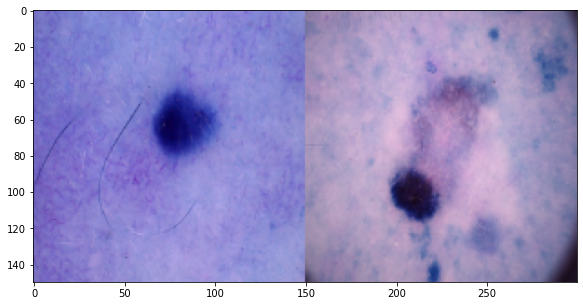

Normal v/s skin-cancer images


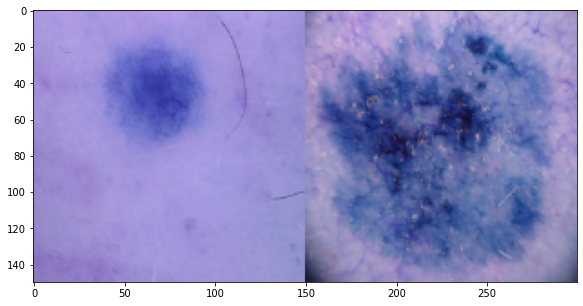

Normal v/s skin-cancer images


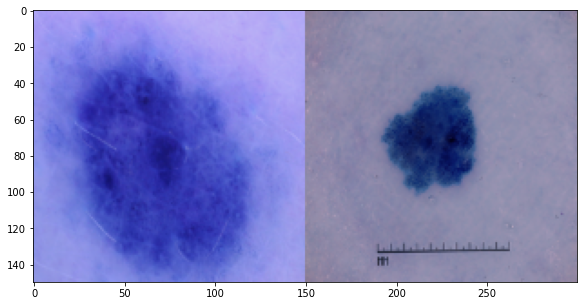

Normal v/s skin-cancer images


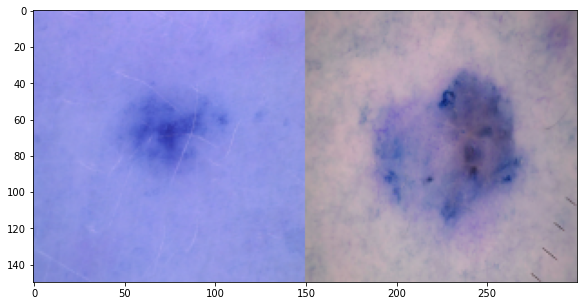

Normal v/s skin-cancer images


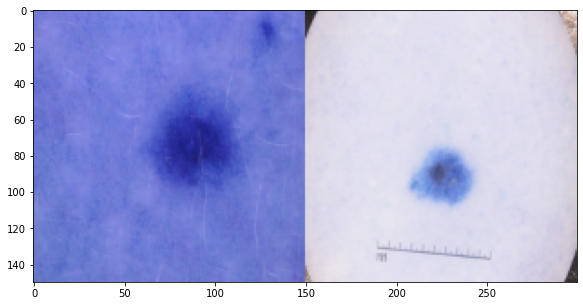

In [8]:
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage.transform import resize
import numpy as np
def plotter(i):
    normal = cv2.imread(Data_Dir+"benign//"+Nimages[i])
    normal = skimage.transform.resize(normal, (150, 150, 3))
    cancer = cv2.imread(Data_Dir+"malignant//"+Cimages[i])
    cancer = skimage.transform.resize(cancer, (150, 150, 3) , mode = 'reflect')
    pair = np.concatenate((normal, cancer), axis=1)
    print("Normal v/s skin-cancer images")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(0,5):
    plotter(i)

In [9]:
LB = LabelBinarizer()  #Initialize label binarizer
labels = LB.fit_transform(labels)
labels = to_categorical(labels); print(labels)
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [10]:
bModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))  #base_Model
hModel = bModel.output #head_Model
hModel = AveragePooling2D(pool_size=(4, 4))(hModel)
hModel = Flatten(name="flatten")(hModel)
hModel = Dense(64, activation="relu")(hModel)
hModel = Dropout(0.5)(hModel)
hModel = Dense(2, activation="softmax")(hModel)
model = Model(inputs=bModel.input, outputs=hModel)
for layer in bModel.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [11]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((528, 224, 224, 3), (132, 224, 224, 3), (528, 2), (132, 2))

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


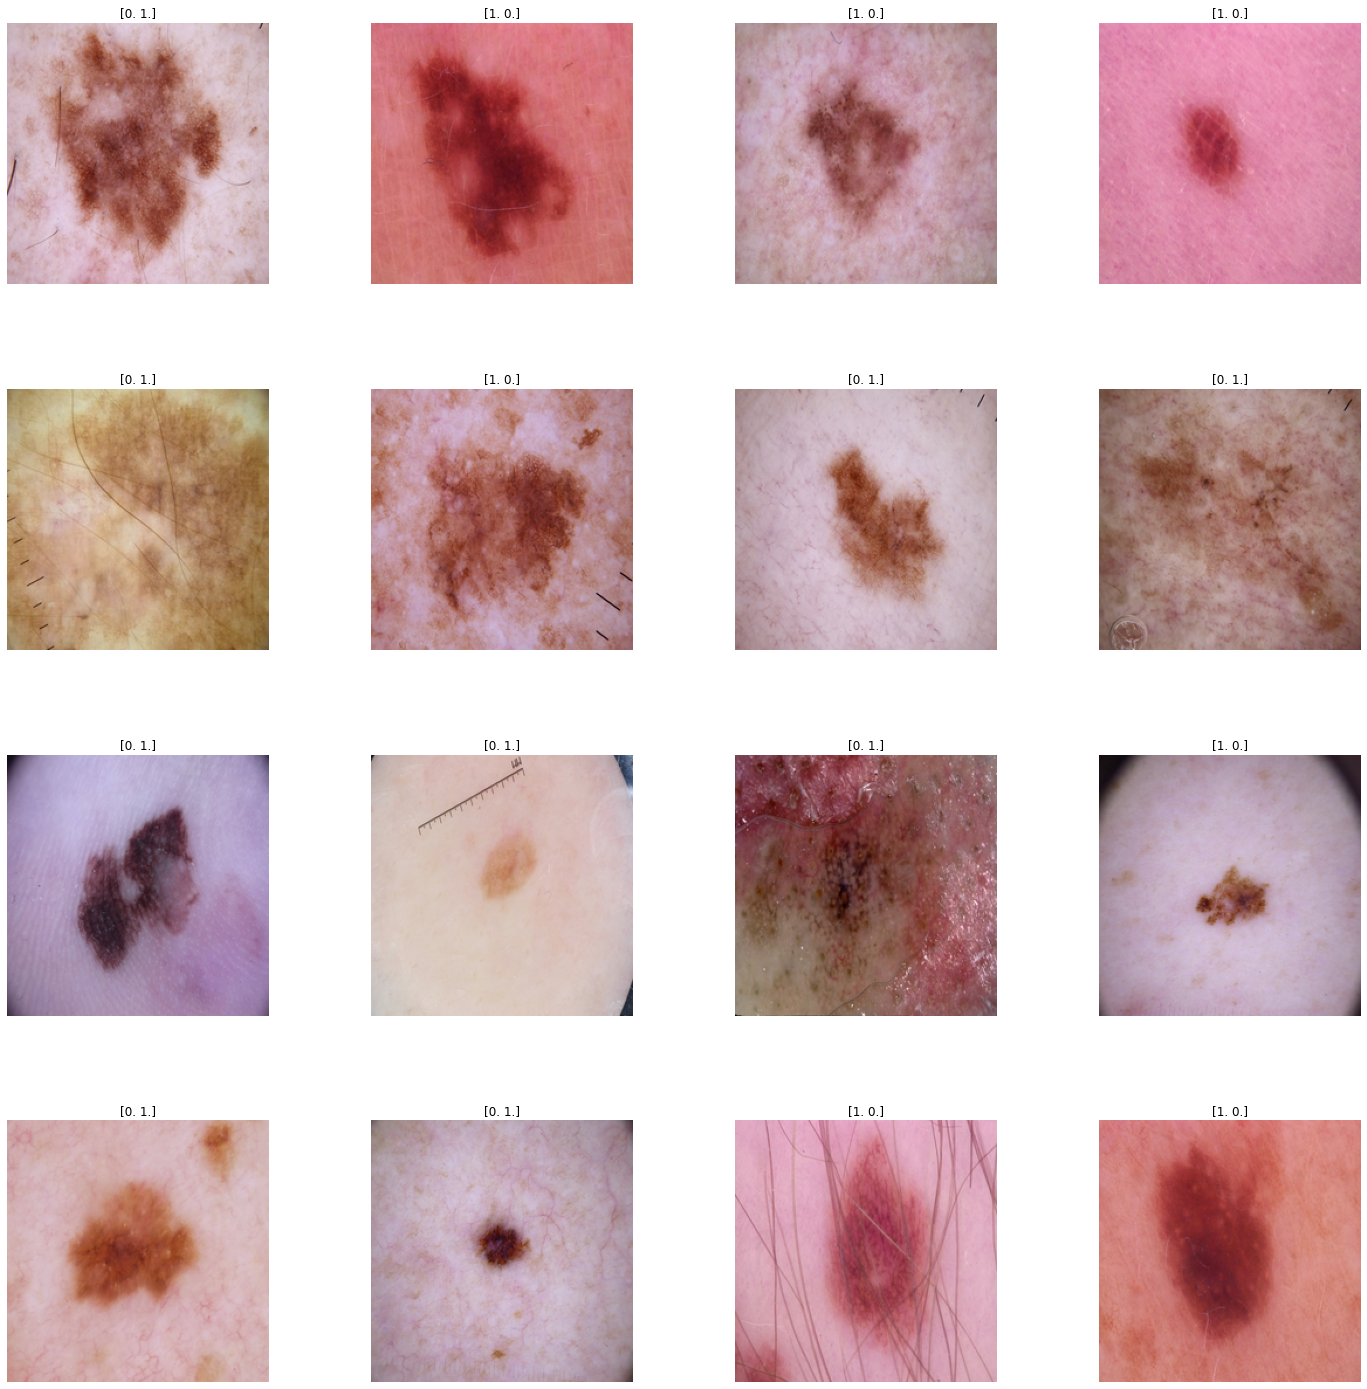

In [12]:
W_grid = 4 #width
L_grid = 4 #lenth
fig, axes = plt.subplots(L_grid, W_grid, figsize = (25, 25)) #subplots
axes = axes.ravel()
n_training = len(X_train)
for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(X_train[index])
    axes[i].set_title(Y_train[index])
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)

In [15]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("Compiling Starts")
R = model.fit_generator(
    trainAug.flow(X_train, Y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, Y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS)
# model.save('/content/gdrive/My Drive/skin-cancer-dataset/skin-cancer-model.h5')

Compiling Starts
Epoch 1/20
66/66 [==============================] - 8s 114ms/step - loss: 0.4450 - accuracy: 0.7917 - val_loss: 0.3742 - val_accuracy: 0.8561
Epoch 2/20
66/66 [==============================] - 7s 99ms/step - loss: 0.4421 - accuracy: 0.7727
Epoch 3/20
66/66 [==============================] - 7s 99ms/step - loss: 0.4232 - accuracy: 0.8011
Epoch 4/20
66/66 [==============================] - 6s 98ms/step - loss: 0.4259 - accuracy: 0.7936
Epoch 5/20
66/66 [==============================] - 7s 99ms/step - loss: 0.4108 - accuracy: 0.8182
Epoch 6/20
66/66 [==============================] - 7s 99ms/step - loss: 0.4137 - accuracy: 0.8049
Epoch 7/20
66/66 [==============================] - 7s 99ms/step - loss: 0.4051 - accuracy: 0.8220
Epoch 8/20
66/66 [==============================] - 6s 98ms/step - loss: 0.4053 - accuracy: 0.8068
Epoch 9/20
66/66 [==============================] - 6s 98ms/step - loss: 0.4063 - accuracy: 0.8087
Epoch 10/20
66/66 [==============================

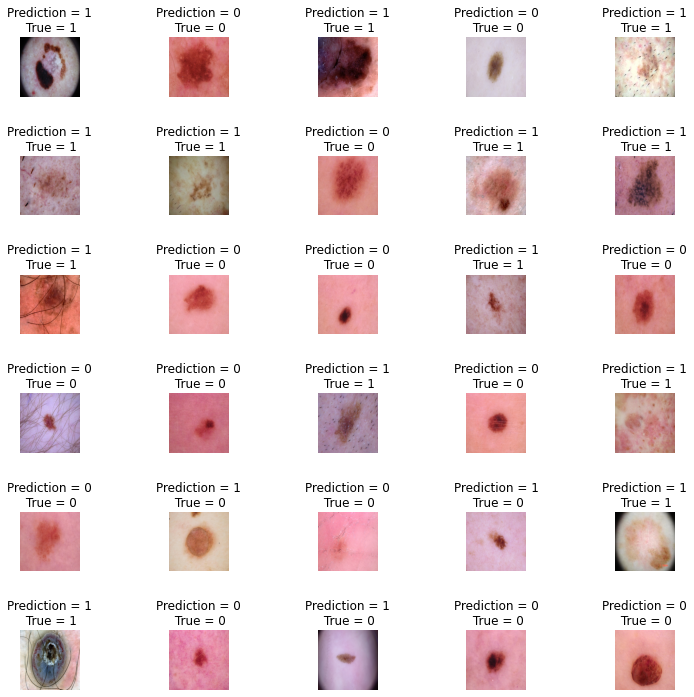

In [16]:
L = 6
W = 5
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
y_pred = model.predict(X_test, batch_size=BS)
for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(y_pred.argmax(axis=1)[i], Y_test.argmax(axis=1)[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1, hspace=1)   

In [17]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test, batch_size=BS)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(Y_test.argmax(axis=1), y_pred,target_names=LB.classes_))

              precision    recall  f1-score   support

      benign       0.92      0.75      0.82        72
   malignant       0.75      0.92      0.83        60

    accuracy                           0.83       132
   macro avg       0.83      0.83      0.83       132
weighted avg       0.84      0.83      0.83       132



In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test.argmax(axis=1),y_pred)

0.8257575757575758

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test.argmax(axis=1), y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[54 18]
 [ 5 55]]
acc: 0.8258
sensitivity: 0.7500
specificity: 0.9167


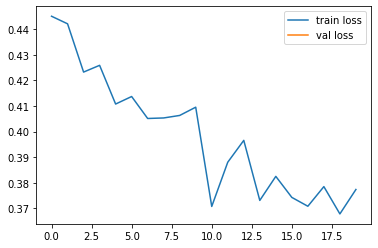

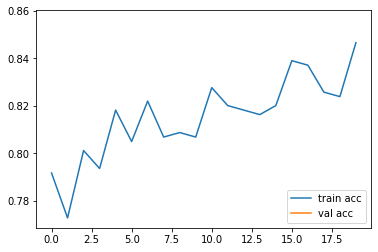

In [20]:
# plot the loss
plt.plot(R.history['loss'], label='train loss')
plt.plot(R.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(R.history['accuracy'], label='train acc')
plt.plot(R.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [21]:
model.save('/content/gdrive/My Drive/skin-cancer-dataset/skin-cancer-model2.h5')

Prediction: Skin-Cancer


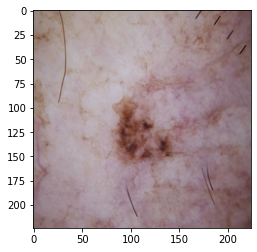

In [22]:
import tensorflow as tf 
from keras.preprocessing import image
#from keras.models import load_model
model = tf.keras.models.load_model('/content/gdrive/My Drive/skin-cancer-dataset/skin-cancer-model2.h5')
from keras.applications.vgg16 import preprocess_input
img = image.load_img('/content/gdrive/My Drive/skin-cancer-dataset/malignant/1027.jpg', target_size=(224, 224)) #insert a random image of skin infection 
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)
if New_pred==[1]:
  print('Prediction: Skin-Cancer')
else:
  print('Prediction: Normal')

In [24]:
#tf-to-tflite

My_TFlite_Model = tf.keras.models.load_model('/content/gdrive/My Drive/skin-cancer-dataset/skin-cancer-model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(My_TFlite_Model)
tflite_model = converter.convert()
open("/content/gdrive/My Drive/skin-cancer-dataset/skin-cancer-model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp4rhpzbrf/assets


INFO:tensorflow:Assets written to: /tmp/tmp4rhpzbrf/assets


59000512